## Goal

Test the multichannel QRD-LSL (M-QRD-LSL) algorithm from [1] vs. the single channel QRD-LSL algorithm from [2] for a single channel of data to ensure everything is working well.

The notebook can be found [here](https://github.com/pchrapka/brain-modelling/tree/master/experiments/exp06-mqrd-lsl).

### Notes

The first few iterations of the M-QRD-LSL algorithm will probably contain warnings of singular matrices. The number of iterations seems to depend on the filter length. This results from recovering the reflection coefficients which requires backsubstitution after each iteration of the algorithm. 

This step may be omitted if the main use of the filter is an adaptive filter. In my case, estimating the coefficients is my primary objective.

An additional concern during the first few iterations of the M-QRD-LSL algorithm is that the parameter $\gamma$ degenerates. This results in a division by 0 and NaNs in the subsequent iterations. This issue is resolved in MQRDLSL1 by resetting $\gamma^{-1}$ to 0 as suggested by [3]. In MQRDLSL2 it is resolved by resettting $\gamma^{2}$ to 1. Empirically this seems to work.

### References

[1] P. S. Lewis, “QR-based algorithms for multichannel adaptive least squares lattice filters,” IEEE Transactions on Acoustics, Speech and Signal Processing, vol. 38, no. 3, pp. 421–432, Mar. 1990.

[2] S. Haykin, Adaptive filter theory, 4th ed. 2002.

[3] B. Friedlander, “Lattice filters for adaptive processing,” Proceedings of the IEEE, vol. 70, no. 8, pp. 829–867, Aug. 1982.



In [2]:
% Initialize the environment
curdir = pwd;
cd ~/projects/brain-modelling
startup
cd(curdir)

## Generate AR data

In [9]:
nsamples = 1000;
a_coefs = [1 -1.6 0.95]';  % from Friedlander1982, case 1
[x,~] = gen_stationary_ar(a_coefs,nsamples);

1


## Estimate the AR coefficients

In [10]:
order = 2;
[a_est, e] = lpc(x, order)

a_est =

    1.0000   -1.5883    0.9399


e =

    1.0390


## Estimate the Reflection coefficients from the AR coefficients

In [11]:
[~,~,k_est] = rlevinson(a_est,e)

k_est =

   -0.8187
    0.9399


## Estimate the Reflection coefficients using the QRD-LSL algorithm

In [12]:
i=1;
lattice = [];

channels = 1;
order = 2;
lambda = 0.99;
lattice(i).alg = MQRDLSL1(channels,order,lambda);
%lattice(i).alg = MQRDLSL2(channels,order,lambda);
lattice(i).scale = -1;
lattice(i).name = sprintf('MQRDLSL C%d P%d lambda=%0.2f',channels,order,lambda);
i = i+1;

M = 2;
lambda = 0.99;
lattice(i).alg = QRDLSL(M,lambda);
lattice(i).scale = 1;
lattice(i).name = sprintf('QRDLSL M%d lambda=%0.2f',M,lambda);
i = i+1;

% estimate the reflection coefficients
lattice = estimate_reflection_coefs(lattice, x);

gammasq is < eps
gammasq is < eps
resetting gamma
gammasq is < eps


## Compare true and estimated

In [13]:
%plot -s 800,600

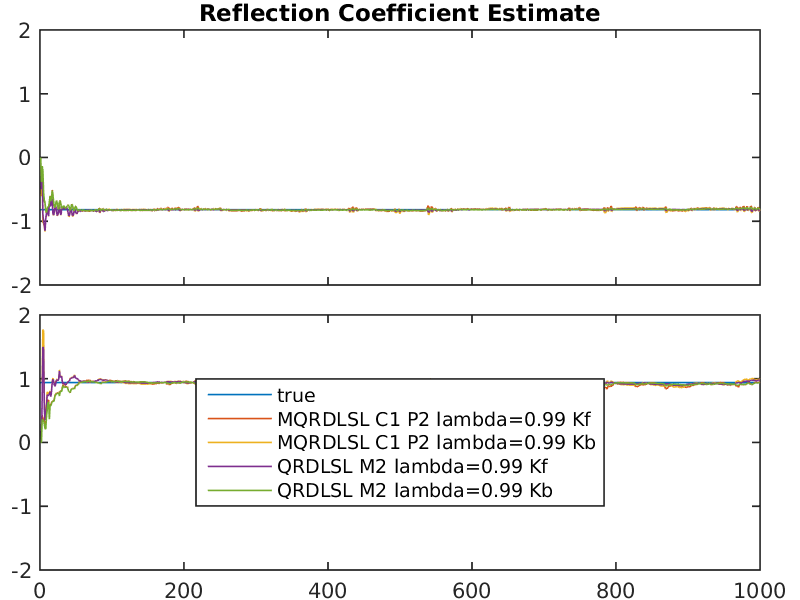

In [14]:
k_true = repmat(k_est,1,nsamples);

figure;
plot_reflection_coefs(lattice, k_true);